# Initiate

In [1]:
import numpy as np
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib as mpl
from cumslip_compute import *
import pandas as pd
import os
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

# Define functions

## Computing functions

In [2]:
def compute_G(dep,time,tstart,tend,cumslip,shearT,quiet=True):
    G,Wr,D,ssd,dsd,Dtot = [],[],[],[],[],[]
    for iev in range(len(tstart)):
        if not quiet:
            print('Event',iev+1)
        Gev,Wev,Dev,ssdev,dsdev,dtotev = [],[],[],[],[],[]
        for idep in np.argsort(abs(dep)):
            its,ite = np.argmin(abs(time[idep]-tstart[iev]))-20, np.argmin(abs(time[idep]-tend[iev]))+20
            x=cumslip[idep][its:ite] - cumslip[idep][its]
            y=shearT[idep][its:ite]
            xb,yb,xr,yr,err_note = get_xy(x,y)
            if not quiet:
                print(err_note)

            if len(xb) == 0:
                Gev.append(np.nan)
                Wev.append(np.nan)
                Dev.append(np.nan)
                dsdev.append(np.nan)
                ssdev.append(np.nan)
                dtotev.append(np.nan)
            else:
                area_b = integrate.simpson(yb-np.min(yb),xb)
                area_r = integrate.simpson(yr-np.min(yr),xr)
                Gev.append(area_b*1e6)
                Wev.append(area_r*1e6)
                Dev.append(xb[-1]-xb[0])
                dsdev.append((yb[0]-np.min(yb))*1e6)
                dtotev.append(np.max(x))
                if len(yr)>0:
                    ssdev.append((yb[0]-yr[-1])*1e6)
                else:
                    ssdev.append((yb[0]-yb[-1])*1e6)
        Gev = np.array(Gev)
        Wev = np.array(Wev)
        Dev = np.array(Dev)
        dsdev = np.array(dsdev)
        ssdev = np.array(ssdev)
        dtotev = np.array(dtotev)

        if len(G) == 0:
            G = Gev.copy()
            Wr = Wev.copy()
            D = Dev.copy()
            dsd = dsdev.copy()
            ssd = ssdev.copy()
            Dtot = dtotev.copy()
        else:
            G = np.vstack((G,Gev))
            Wr = np.vstack((Wr,Wev))
            D = np.vstack((D,Dev))
            dsd = np.vstack((dsd,dsdev))
            ssd = np.vstack((ssd,ssdev))
            Dtot = np.vstack((Dtot,dtotev))
    return G,D,dsd,Wr,ssd,Dtot

def load_csv(fnames):
    G,D,L = [],[],[]
    for fn in fnames:
        if not 'reference' in fn:
            print(fn)
            df = pd.read_csv(fn,sep=';',encoding= 'unicode_escape',usecols=['value (J/m^2)','value (m)'],na_values= ['#DIV/0!',' '],dtype='float').dropna().to_numpy().T
            L.append(len(df[0]))
            Gi,Di = df[0],df[1]
            if len(G) == 0:
                G = Gi.copy()
                D = Di.copy()
            else:
                G = np.hstack((G,Gi))
                D = np.hstack((D,Di))
    return G,D,np.array(L)

def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)

def get_xy(x,y):
    err_note = ''
    if sum(x<0) > 0:
        err_note += 'negative cumslip adjusted '
        x = abs(x)
    while not np.all(np.diff(x) > 0.0):
        if len(np.where(np.diff(x)<0)[0]) > 0:
            err_note += '/ decreasing cumslip adjusted '
            x[np.where(np.diff(x)<0)[0]] = (x[np.where(np.diff(x)<0)[0]-1]+x[np.where(np.diff(x)<0)[0]+1])/2
        ix = np.where(np.diff(x) > 0)[0]+1
        x = x[ix]; y = y[ix]
    if len(np.where(np.diff(x) > 0)[0]) < 2:
        err_note += '/ no points left - discarded'
        xb,yb,xr,yr = [],[],[],[]
    else:
        if len(x) < 500:
            fx = interpolate.interp1d(np.arange(len(x)),x)
            fy = interpolate.interp1d(np.arange(len(y)),y)
            x = fx(np.linspace(0,len(x)-1,500))
            y = fy(np.linspace(0,len(y)-1,500))
        xb = x[:np.argmin(y)+1]; yb = y[:np.argmin(y)+1]
        xr = x[np.argmin(y):]; yr = y[np.argmin(y):]
        if len(np.where(np.diff(xb) > 0)[0]) < 2:
            err_note += '/ no points left2 - discarded2'
            xb,yb,xr,yr = [],[],[],[]
    if len(err_note) > 0 and err_note[0] == '/':
        err_note = err_note[2:]
    return xb,yb,xr,yr,err_note

def logxy(xr,b1,b0):
    y = np.power(10,b0 + b1*np.log10(xr))
    return y

def minmax(rmin,rmax,var,zero_out=False):
    if zero_out:
        varmin = np.nanmin(var[var>0])
    else:
        varmin = np.nanmin(var)
    if varmin < rmin:
        rmin = varmin
    if np.nanmax(var) > rmax:
        rmax = np.nanmax(var)
    return rmin,rmax

## Plotting functions

In [3]:
def slip_vs_stress_test(ax,x,y,txt=None,col='k',lw=2.5,yl=None):
    ax.plot(x,y,color=col,lw=lw)
# def slip_vs_stress_test(ax,x,y,txt=None,lw=2.5,yl=None):
    # ax.plot(x,y,lw=lw)
    if txt is not None:
        # ax.text(np.max(x),np.max(y),txt,fontsize=15,fontweight='bold',ha='right',va='top')
        ax.text(np.min(x),np.max(y),txt,fontsize=15,fontweight='bold',ha='left',va='top')
    ax.set_xlabel('Slip [m]',fontsize=17)
    ax.set_ylabel('Shear Stress [MPa]',fontsize=17)
    if yl is not None:
        ax.set_ylim(yl)
    ax.grid(True,alpha=0.5)

def slip_vs_stress(ax,x,y,txt=None):
    xb,yb,xr,yr,err_note = get_xy(x,y)
    ax.fill_between(xb,yb,np.min(yb),color=mp.mylavender,alpha=0.3)
    ax.fill_between(xr,yr,np.min(yr),color=mp.myblue,alpha=0.3)
    ax.plot(x,y,'k',lw=2.5)
    if txt is not None:
        ax.text(np.max(x),np.max(y),txt,fontsize=15,fontweight='bold',ha='right',va='top')
    ax.set_xlabel('Slip [m]',fontsize=17)
    ax.set_ylabel('Shear Stress [MPa]',fontsize=17)
    ax.grid(True,alpha=0.5)

def show_zoom(ax,dep,time,tstart,tend,var,idep,iev,add,varname):
    its,ite = np.argmin(abs(time[idep]-tstart[iev])), np.argmin(abs(time[idep]-tend[iev]))
    rect=plt.Rectangle(xy=(time[idep][its],np.min(var[idep][its-add:ite+add])),width=time[idep][ite]-time[idep][its],height=np.max(var[idep][its-add:ite+add])-np.min(var[idep][its-add:ite+add]),facecolor='lemonchiffon',linewidth=2,edgecolor='goldenrod')
    ax.add_patch(rect)
    ax.plot(time[idep][its-add:ite+add],var[idep][its-add:ite+add],'k',lw=2)
    ax.text(np.min(time[idep][its-add:ite+add]),np.max(var[idep][its-add:ite+add]),'Depth: %2.1f km\nEvent #: %d'%(np.sort(abs(dep))[idep],iev),fontsize=15,fontweight='bold',ha='left',va='top')
    ax.set_xlabel('Time [s]',fontsize=17)
    if varname == 'sr':
        ax.hlines(y=-2,xmin=time[idep][its-add],xmax=time[idep][ite+add],color=mp.myburgundy,linestyles='--',lw=2)
        ax.set_ylabel(r'$\log_{10}$(Slip Rate [m/s])',fontsize=17)
    elif varname == 'cumslip':
        ax.set_ylabel('Cumulative Slip [m]',fontsize=17)
    elif varname == 'shearT':
        ax.set_ylabel('Shear Stress [MPa]',fontsize=17)
    ax.grid(True,alpha=0.5)
    # ax.scatter(time[idep][its-add:ite+add],var[idep][its-add:ite+add],s=9,color='k')

def G_prof_single(ax,G,dep,iev,Hs):
    ax.plot(G,np.sort(abs(dep)),'k',lw=3)
    ax.set_xscale('log')
    ax.set_ylim(0,Hs[0])
    ax.set_title('Event # %d'%(iev),fontsize=20,fontweight='bold')
    ax.set_xlabel('G [J/m$^2$]',fontsize=17)
    ax.set_ylabel('Depth [km]',fontsize=17)
    ax.grid(True,alpha=0.5)
    ax.invert_yaxis()

def G_prof_all(ax,G,cumslip_outputs,avD,ev_idx,ev_type,Hs,var_mode):
    if ev_type == 'sw':
        # system-wide
        cmap = mpl.colormaps['gnuplot']
    elif ev_type == 'pr':
        # partial rupture
        cmap = mpl.colormaps['ocean']
    else:
        NameError('Wrong value for event type - choose either ''sw'' or ''pr''')
    fault_z = np.array(cumslip_outputs[3][1]).T[0]
    if len(ev_idx) > 0:
        ax.set_prop_cycle('color',[cmap(i) for i in np.linspace(0.5,0.9,len(ev_idx))]) 
        ax.plot(G[ev_idx].T,np.array([fault_z for i in range(len(ev_idx))]).T,lw=3,label=[r'Event %d ($\bar{D}$ = %2.2f m)'%(i,avD[i]) for i in ev_idx])
        hyp_dep = cumslip_outputs[1][1][ev_idx]
        hyp_slip = [G[ev_idx][i][np.where(fault_z==hyp_dep[i])[0][0]] for i in range(len(ev_idx))]
        # ax.scatter(hyp_slip,hyp_dep,marker='*',s=300,facecolor=mp.mydarkviolet,edgecolors='k',lw=1,zorder=3,label='Hypocenter')
        ax.scatter(hyp_slip,hyp_dep,300,marker='*',c=[cmap(i) for i in np.linspace(0.5,0.9,len(ev_idx))],edgecolors='k',lw=1.5,zorder=3,label='Hypocenter')
        ax.legend(fontsize=13,loc='lower right')
    else:
        IndexError('No event for chosen type')
    ax.set_xscale('log')
    ax.set_ylim(0,Hs[0])
    if var_mode == 'Wb':
        ax.set_xlabel('Wb [J/m$^2$]',fontsize=17)
    elif var_mode == 'Wr':
        ax.set_xlabel('Wr [J/m$^2$]',fontsize=17)
    ax.set_ylabel('Depth [km]',fontsize=17)
    ax.grid(True,alpha=0.5)
    ax.invert_yaxis()

def scaling(ax,D,G,col,lab=None,s=4,marker='o',ec=None,lw=1.5,zord=1,alpha=None,xl=[1e-9,1e2],yl=[1e-6,1e9],av=True,cmap_n='magma_r'):
    if len(col) == len(D):
        cmap = mpl.colormaps[cmap_n]
        col = cmap(col.flatten())
    if ec is not None:
        if len(ec) == len(D):
            cmap = mpl.colormaps[cmap_n]
            ec = cmap(ec.flatten())
        psc = ax.scatter(D,G,s=s,marker=marker,fc=col,label=lab,zorder=zord,ec=ec,lw=lw,alpha=alpha)
    else:
        psc = ax.scatter(D,G,s=s,marker=marker,fc=col,label=lab,zorder=zord,alpha=alpha)
    if lab is not None:
        ax.legend(fontsize=13,loc='lower right')
    if av:
        ax.set_xlabel('Average Slip [m]',fontsize=17)
        ax.set_ylabel('Average Fracture Energy Density [J/m$^2$]',fontsize=17)
    else:
        ax.set_xlabel('Slip [m]',fontsize=17)
        ax.set_ylabel('Fracture Energy Density [J/m$^2$]',fontsize=17)
    if xl != 'auto':
        ax.set_xlim(xl)
    if yl != 'auto':
        ax.set_ylim(yl)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True,alpha=0.5)
    return psc

def plot_Coccos(ax,follow_color=False,legend_on=True):
    cocco_outputs = np.load('/Users/j4yun/Dropbox/Coursework/2023-S_Advanced_Seismology_2/Final_project/outputs/Cocco/outputs.npy',allow_pickle=True)
    Gcc = cocco_outputs.item().get('G')
    Dcc = cocco_outputs.item().get('D')
    Lcc = cocco_outputs.item().get('L')
    labels = cocco_outputs.item().get('labels')

    if not follow_color:
        cmap = mpl.colormaps['YlGn']
        spacing = np.linspace(0.7,0.3,len(Lcc))
        colset = cmap(spacing)
    else:
        colset = ['k',(128/255,205/255,230/255),'tomato','goldenrod']

    c = 0
    pts = []
    for i in range(len(Lcc)):
        if i==0:
            if legend_on:
                sc = scaling(ax,Dcc[c:c+Lcc[i]],Gcc[c:c+Lcc[i]],colset[i],lab=labels[i],zord=3,alpha=0.25,yl='auto')
            else:
                sc = scaling(ax,Dcc[c:c+Lcc[i]],Gcc[c:c+Lcc[i]],colset[i],zord=3,alpha=0.25,yl='auto')
        else:
            if legend_on:
                sc = scaling(ax,Dcc[c:c+Lcc[i]],Gcc[c:c+Lcc[i]],colset[i],lab=labels[i],zord=2,alpha=0.25,yl='auto')
            else:
                sc = scaling(ax,Dcc[c:c+Lcc[i]],Gcc[c:c+Lcc[i]],colset[i],zord=2,alpha=0.25,yl='auto')
        c += Lcc[i]
        pts.append(sc)
    return pts,labels

def avG_event(ax,var,tstart,system_wide,partial_rupture,type,spin_up_idx,c1=mp.myburgundy,c2=mp.mynavy):
    yl = [4,11.2]
    # ax.add_patch(Rectangle((spin_up_idx+0.5,0),len(tstart)-spin_up_idx-1,yl[1],fc='0.8',alpha=0.5))
    ax.add_patch(Rectangle((-0.5,0),spin_up_idx+1,yl[1],fc='0.8',alpha=0.5))
    markers, stemlines, baseline = ax.stem(system_wide,np.log10(var[system_wide]), label='System-wide')
    plt.setp(stemlines, color=c1, linewidth=2.5)
    plt.setp(markers, color=c1, marker='s')

    if len(partial_rupture) > 0:
        markers, stemlines, baseline = ax.stem(partial_rupture,np.log10(var[partial_rupture]), label='Partial rupture')
        plt.setp(stemlines, color=c2, linewidth=2.5)
        plt.setp(markers, color=c2, marker='d', ms=9)

    ax.legend(fontsize=11.5,loc='upper left')
    ax.set_xlabel('Event index',fontsize=17)
    if type == 'G':
        ax.set_ylabel('$\log$(G [J/m$^2$])',fontsize=17)
    elif type == 'D':
        ax.set_ylabel('$\log$(slip [m])',fontsize=17)
    ax.set_xticks(np.arange(0,len(tstart),1))
    ax.set_xlim(-len(tstart)*0.05,(len(tstart)-1)*1.05)
    ax.set_ylim(yl)

def scatter_xy(ax,x,y,col,lab=None,s=4,marker='o',ec=None,lw=1.5,zord=1,alpha=None,xl='auto',yl='auto',labx='Wr [J/m$^2$]',laby='Wb [J/m$^2$]',cmap_n='magma_r'):
    if len(col) == len(x):
        cmap = mpl.colormaps[cmap_n]
        col = cmap(col.flatten())
    if len(ec) == len(x):
        cmap = mpl.colormaps[cmap_n]
        ec = cmap(ec.flatten())
    psc = ax.scatter(x,y,s=s,marker=marker,fc=col,label=lab,zorder=zord,ec=ec,lw=lw,alpha=alpha)
    ax.set_xlabel(labx,fontsize=17)
    ax.set_ylabel(laby,fontsize=17)
    if xl != 'auto':
        ax.set_xlim(xl)
    if yl != 'auto':
        ax.set_ylim(yl)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True,alpha=0.5)
    return psc

# Compilation across various models

In [ ]:
prefix_list = ['BP1',
               'Thakur20_hetero_stress/n8_v6',
               'Thakur20_various_fractal_profiles/ab2',
               'Thakur20_various_fractal_profiles/Dc1',
               'Thakur20_various_fractal_profiles/v6_ab2_Dc2',
               'Thakur20_various_fractal_profiles/v6_Dc1_long',
               'Thakur20_various_fractal_profiles/v6_ab2',
               'Thakur20_various_fractal_profiles/ab2_Dc1']
labs = ['BP1','Fractal Stress','Fractal a-b','Fractal Dc','Fractal Stress & a-b & Dc','Fractal Stress & Dc','Fractal Stress & a-b','Fractal a-b & Dc']
cols = [mp.myburgundy,mp.mylavender,mp.mynavy,mp.myblue,mp.myyellow,mp.mypalepink,mp.myorange,'turquoise']
dir = '/Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem'

## Scaling law 
After spin-up, not averaged

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))
# pts,labels = plot_Coccos(ax,follow_color=False,legend_on=False)
# first_legend = plt.legend(handles=pts,labels=labels,fontsize=12,framealpha=0,loc='lower right',markerscale=2.)
# plt.gca().add_artist(first_legend)

pts = []
Gmax = -1e9; Gmin = 1e23
Dmax = -1e9; Dmin = 1e23
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    D = outputs.item().get('D')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw = scaling(ax,D[system_wide[system_wide>=spin_up_idx]],G[system_wide[system_wide>=spin_up_idx]],cols[uu],
                 lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,av=False)
    Gmin,Gmax = minmax(Gmin,Gmax,G[system_wide[system_wide>=spin_up_idx]])
    Dmin,Dmax = minmax(Dmin,Dmax,D[system_wide[system_wide>=spin_up_idx]])
    
    if len(partial_rupture) > 0 and sum(partial_rupture<spin_up_idx) > 0:
        pr = scaling(ax,D[partial_rupture[partial_rupture>=spin_up_idx]],G[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],
                     lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,av=False)
        Gmin,Gmax = minmax(Gmin,Gmax,G[partial_rupture[partial_rupture>=spin_up_idx]])
        Dmin,Dmax = minmax(Dmin,Dmax,D[partial_rupture[partial_rupture>=spin_up_idx]])

        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
        
print(np.log10(Gmin),np.log10(Gmax))
print(np.log10(Dmin),np.log10(Dmax))
ax.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
ax.set_xlim(1e-12,5e1)
ax.set_ylim(1e-11,5e13)
plt.tight_layout()
if save_on:
    plt.savefig('plots/scaling_compiled',dpi=300)
plt.show()

## Scaling law color by Wr
After spin-up, not averaged

In [ ]:
save_on = 0
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))

rmin,rmax = 1e23,-1e6
for uu,prefix in enumerate(prefix_list):
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    Wr = outputs.item().get('Wr')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    rmin,rmax = minmax(rmin,rmax,Wr[system_wide[system_wide>=spin_up_idx]],zero_out=True)
    if len(partial_rupture) > 0 and sum(partial_rupture<spin_up_idx) > 0:
        rmin,rmax = minmax(rmin,rmax,Wr[partial_rupture[partial_rupture>=spin_up_idx]],zero_out=True) 
print(np.log10(rmin),np.log10(rmax))

cmap_n = 'Spectral_r'
cmap = mpl.cm.ScalarMappable(cmap=mpl.colormaps[cmap_n])
cmap.set_array([])

rmin,rmax = 1e23,-1e6
for uu,prefix in enumerate(prefix_list):
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    Wr = outputs.item().get('Wr')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    rmin,rmax = minmax(rmin,rmax,Wr[system_wide[system_wide>=spin_up_idx]],zero_out=True)
    if len(partial_rupture) > 0 and sum(partial_rupture<spin_up_idx) > 0:
        rmin,rmax = minmax(rmin,rmax,Wr[partial_rupture[partial_rupture>=spin_up_idx]],zero_out=True) 

print(np.log10(rmin),np.log10(rmax))
pts = []
for uu,prefix in enumerate(prefix_list):
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    D = outputs.item().get('D')
    Wr = outputs.item().get('Wr')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    Wr[np.isnan(Wr)] = 0.
    Wr -= rmin
    Wr /= rmax

    sw = scaling(ax,D[system_wide[system_wide>=spin_up_idx]],G[system_wide[system_wide>=spin_up_idx]],'none',
                 ec=Wr[system_wide[system_wide>=spin_up_idx]],s=36,marker='s',lw=1,zord=3,av=False,cmap_n=cmap_n)
    if len(partial_rupture) > 0 and sum(partial_rupture<spin_up_idx) > 0:
        pr = scaling(ax,D[partial_rupture[partial_rupture>=spin_up_idx]],G[partial_rupture[partial_rupture>=spin_up_idx]],'none',
                     ec=Wr[partial_rupture[partial_rupture>=spin_up_idx]],s=50,marker='d',lw=1,zord=3,av=False,cmap_n=cmap_n)
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
        
plt.colorbar(cmap,ax=ax).set_label('Normalized Wr',fontsize=17,rotation=270,labelpad=30)
ax.set_xlim(1e-10,5e1)
ax.set_ylim(1e-11,5e13)

plt.tight_layout()
if save_on:
    plt.savefig('plots/scaling_compiled_byWb',dpi=300)
plt.show()

## Linear proportionality
After spin-up data

In [ ]:
save_on = 1
xr = [1e-3,1e1]
yr = [1e2,2.5e11]

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(10,8))
plot_Coccos(ax,follow_color=False,legend_on=False)

pts,x,y = [],[],[]
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw=scaling(ax,avD[system_wide[system_wide>=spin_up_idx]],avG[system_wide[system_wide>=spin_up_idx]],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl=yr,xl=xr)
    xx = avD[system_wide[system_wide>=spin_up_idx]]
    yy = avG[system_wide[system_wide>=spin_up_idx]]
    if len(x) == 0:
        x = xx.copy()
        y = yy.copy()
    else:
        x = np.hstack((x,xx))
        y = np.hstack((y,yy))
    if len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
        pr=scaling(ax,avD[partial_rupture[partial_rupture>=spin_up_idx]],avG[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl=yr,xl=xr)
        xx = avD[partial_rupture[partial_rupture>=spin_up_idx]]
        yy = avG[partial_rupture[partial_rupture>=spin_up_idx]]
        x = np.hstack((x,xx))
        y = np.hstack((y,yy))
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
first_legend = plt.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.gca().add_artist(first_legend)

b = estimate_coef(np.log10(x), np.log10(y))
y_pred = logxy(xr,b[1],b[0])
l1,=ax.plot(xr,logxy(xr,1.39,7.3),'0.5',lw=2.5,label='1.39 Cocco et al. 2016')
l2,=ax.plot(xr,logxy(xr,1.35,7.2),'0.6',lw=2.5,label='1.35 Causse et al. 2014')
l3,=ax.plot(xr,logxy(xr,1.28,6.975),'0.7',lw=2.5,label='1.28 Abercrombie & Rice 2005')
l4,=ax.plot(xr,y_pred,color='chocolate',lw=3,label='%2.2f %s'%(b[1],'This study'))
ax.legend(handles=[l4,l1,l2,l3],fontsize=10,framealpha=0,loc='lower right')

plt.tight_layout()
if save_on:
    plt.savefig('plots/linear_prop',dpi=300)
plt.show()

## Linear proportionality - by model

In [ ]:
save_on = 1
xr = [1e-3,1e1]
yr = [1e2,2.5e11]

ncol = 4
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(nrows=2,ncols=ncol,figsize=(32,16))

cc = 0
for uu,prefix in enumerate(prefix_list):
    nr,nc = int(cc/ncol),np.mod(cc,ncol)
    trends,x,y = [],[],[]
    save_dir = 'models/' + prefix
    plot_Coccos(ax[nr,nc],follow_color=False,legend_on=False)
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw=scaling(ax[nr,nc],avD[system_wide[system_wide>=spin_up_idx]],avG[system_wide[system_wide>=spin_up_idx]],cols[uu],lab='%s; System-wide'%(labs[uu]),s=54,marker='s',ec='k',lw=1,zord=3,yl=yr,xl=xr)
    xx = avD[system_wide[system_wide>=spin_up_idx]]
    yy = avG[system_wide[system_wide>=spin_up_idx]]
    if len(x) == 0:
        x = xx.copy()
        y = yy.copy()
    else:
        x = np.hstack((x,xx))
        y = np.hstack((y,yy))
    if len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
        pr=scaling(ax[nr,nc],avD[partial_rupture[partial_rupture>=spin_up_idx]],avG[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=75,marker='d',ec='k',lw=1,zord=3,yl=yr,xl=xr)
        xx = avD[partial_rupture[partial_rupture>=spin_up_idx]]
        yy = avG[partial_rupture[partial_rupture>=spin_up_idx]]
        x = np.hstack((x,xx))
        y = np.hstack((y,yy))

    b = estimate_coef(np.log10(x), np.log10(y))
    y_pred = logxy(xr,b[1],b[0])
    l4,=ax[nr,nc].plot(xr,y_pred,color=cols[uu],lw=3,label='%2.2f %s'%(b[1],labs[uu]))
    trends.append(l4)

    l1,=ax[nr,nc].plot(xr,logxy(xr,1.39,7.3),'0.5',lw=2.5,label='1.39 Cocco et al. 2016')
    trends.append(l1)
    l2,=ax[nr,nc].plot(xr,logxy(xr,1.35,7.2),'0.6',lw=2.5,label='1.35 Causse et al. 2014')
    trends.append(l2)
    l3,=ax[nr,nc].plot(xr,logxy(xr,1.28,6.975),'0.7',lw=2.5,label='1.28 Abercrombie & Rice 2005')
    trends.append(l3)
    ax[nr,nc].legend(handles=trends,fontsize=10,framealpha=0,loc='lower right')

    ax[nr,nc].set_title('%s'%(labs[uu]),fontsize=20,fontweight='bold')
    if nr == 0:
        ax[nr,nc].axes.xaxis.set_ticklabels([])
        ax[nr,nc].set_xlabel('')
    if nc > 0:
        ax[nr,nc].axes.yaxis.set_ticklabels([])
        ax[nr,nc].set_ylabel('')

    cc+=1

plt.tight_layout()
if save_on:
    plt.savefig('plots/linear_prop_bymodels',dpi=300)
plt.show()

## Linear proportionality - by model; classified

In [ ]:
save_on = 1
xr = [1e-3,1e1]
yr = [1e2,2.5e11]

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(ncols=3,figsize=(25,8))

cc = 0
for uu in [6,7,4]:
# for uu in [0,3,5]:
    prefix = prefix_list[uu]
    trends,x,y = [],[],[]
    plot_Coccos(ax[cc],follow_color=False,legend_on=False)
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw=scaling(ax[cc],avD[system_wide[system_wide>=spin_up_idx]],avG[system_wide[system_wide>=spin_up_idx]],cols[uu],lab='%s; System-wide'%(labs[uu]),s=54,marker='s',ec='k',lw=1,zord=3,yl=yr,xl=xr)
    xx = avD[system_wide[system_wide>=spin_up_idx]]
    yy = avG[system_wide[system_wide>=spin_up_idx]]
    if len(x) == 0:
        x = xx.copy()
        y = yy.copy()
    else:
        x = np.hstack((x,xx))
        y = np.hstack((y,yy))
    if len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
        pr=scaling(ax[cc],avD[partial_rupture[partial_rupture>=spin_up_idx]],avG[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=75,marker='d',ec='k',lw=1,zord=3,yl=yr,xl=xr)
        xx = avD[partial_rupture[partial_rupture>=spin_up_idx]]
        yy = avG[partial_rupture[partial_rupture>=spin_up_idx]]
        x = np.hstack((x,xx))
        y = np.hstack((y,yy))

    b = estimate_coef(np.log10(x), np.log10(y))
    y_pred = logxy(xr,b[1],b[0])
    l4,=ax[cc].plot(xr,y_pred,color=cols[uu],lw=3,label='%2.2f %s'%(b[1],labs[uu]))
    trends.append(l4)

    l1,=ax[cc].plot(xr,logxy(xr,1.39,7.3),'0.5',lw=2.5,label='1.39 Cocco et al. 2016')
    trends.append(l1)
    l2,=ax[cc].plot(xr,logxy(xr,1.35,7.2),'0.6',lw=2.5,label='1.35 Causse et al. 2014')
    trends.append(l2)
    l3,=ax[cc].plot(xr,logxy(xr,1.28,6.975),'0.7',lw=2.5,label='1.28 Abercrombie & Rice 2005')
    trends.append(l3)
    ax[cc].legend(handles=trends,fontsize=10,framealpha=0,loc='lower right')

    ax[cc].set_title('%s'%(labs[uu]),fontsize=20,fontweight='bold')
    if cc > 0:
        ax[cc].axes.yaxis.set_ticklabels([])
        ax[cc].set_ylabel('')

    cc+=1

plt.tight_layout()
if save_on:
    if uu == 5:
        plt.savefig('plots/linear_prop_regular_models',dpi=300)
    elif uu == 4:
        plt.savefig('plots/linear_prop_complex_models',dpi=300)
plt.show()

## Linear proportionality - SW vs. PR

In [ ]:
save_on = 1
ver = 'sw'
# ver = 'pr'
xr = [1e-3,1e1]
yr = [1e2,2.5e11]

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(10,8))
plot_Coccos(ax,follow_color=False,legend_on=False)

pts,x,y = [],[],[]
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))pts = []
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    if ver == 'sw':
        sw=scaling(ax,avD[system_wide[system_wide>=spin_up_idx]],avG[system_wide[system_wide>=spin_up_idx]],cols[uu],lab='%s'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl=yr,xl=xr)
        pts.append(sw)
        xx = (avD[system_wide[system_wide>=spin_up_idx]])
        yy = (avG[system_wide[system_wide>=spin_up_idx]])
        if len(x) == 0:
            x = xx.copy()
            y = yy.copy()
        else:
            x = np.hstack((x,xx))
            y = np.hstack((y,yy))
    elif ver == 'pr' and len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
        pr=scaling(ax,avD[partial_rupture[partial_rupture>=spin_up_idx]],avG[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],lab='%s'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl=yr,xl=xr)
        pts.append(pr)
        xx = (avD[partial_rupture[partial_rupture>=spin_up_idx]])
        yy = (avG[partial_rupture[partial_rupture>=spin_up_idx]])    
        if len(x) == 0:
            x = xx.copy()
            y = yy.copy()
        else:
            x = np.hstack((x,xx))
            y = np.hstack((y,yy))

first_legend = plt.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.gca().add_artist(first_legend)

b = estimate_coef(np.log10(x), np.log10(y))
y_pred = logxy(xr,b[1],b[0])

l1,=ax.plot(xr,logxy(xr,1.39,7.3),'0.5',lw=2.5,label='1.39 Cocco et al. 2016')
l2,=ax.plot(xr,logxy(xr,1.35,7.2),'0.6',lw=2.5,label='1.35 Causse et al. 2014')
l3,=ax.plot(xr,logxy(xr,1.28,6.975),'0.7',lw=2.5,label='1.28 Abercrombie & Rice 2005')
if ver == 'sw':
    l4,=ax.plot(xr,y_pred,color='chocolate',lw=3,label='%2.2f %s'%(b[1],'System-wide events'))
    ax.set_title('System-wide events',fontsize=20,fontweight='bold')
elif ver == 'pr':
    l4,=ax.plot(xr,y_pred,color='chocolate',lw=3,label='%2.2f %s'%(b[1],'Partial rupture events'))
    ax.set_title('Partial rupture events',fontsize=20,fontweight='bold')

ax.legend(handles=[l4,l1,l2,l3],fontsize=10,framealpha=0,loc='lower right')

plt.tight_layout()
if save_on:
    plt.savefig('plots/linear_prop_%s'%(ver),dpi=300)
plt.show()

## Stress drop scaling

In [ ]:
save_on = 1
# s_mode = 'dynamic'
s_mode = 'static'
xr = [1e-3,1e1]
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,8))

pts = []
x_sw,y_sw = [],[]
x_pr,y_pr = [],[]
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    avD = outputs.item().get('avD')
    if s_mode == 'dynamic':
        avsd = outputs.item().get('avdsd')
    elif s_mode == 'static':
        avsd = outputs.item().get('avssd')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw = scaling(ax,avD[system_wide[system_wide>=spin_up_idx]],avsd[system_wide[system_wide>=spin_up_idx]],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,xl=xr,yl='auto')
    pts.append(sw)
    xx_sw = (avD[system_wide[system_wide>=spin_up_idx]])
    yy_sw = (avsd[system_wide[system_wide>=spin_up_idx]])
    if len(partial_rupture) > 0 and sum(partial_rupture<spin_up_idx) > 0:
        pr = scaling(ax,avD[partial_rupture[partial_rupture>=spin_up_idx]],avsd[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,xl=xr,yl='auto')
        pts.append(pr)
        xx_pr = (avD[partial_rupture[partial_rupture>=spin_up_idx]])
        yy_pr = (avsd[partial_rupture[partial_rupture>=spin_up_idx]])
        if len(x_pr) == 0:
            x_pr = xx_pr.copy()
            y_pr = yy_pr.copy()
        else:
            x_pr = np.hstack((x_pr,xx_pr))
            y_pr = np.hstack((y_pr,yy_pr))

    if len(x_sw) == 0:
        x_sw = xx_sw.copy()
        y_sw = yy_sw.copy()
    else:
        x_sw = np.hstack((x_sw,xx_sw))
        y_sw = np.hstack((y_sw,yy_sw))

first_legend = plt.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.gca().add_artist(first_legend)

b = estimate_coef(np.log10(np.hstack((x_sw,x_pr))), np.log10(np.hstack((y_sw,y_pr))))
y_pred_tot = logxy(xr,b[1],b[0])
b_sw = estimate_coef(np.log10(x_sw), np.log10(y_sw))
y_pred_sw = logxy(xr,b_sw[1],b_sw[0])
b_pr = estimate_coef(np.log10(x_pr), np.log10(y_pr))
y_pred_pr = logxy(xr,b_pr[1],b_pr[0])

l1,=ax.plot(xr,y_pred_tot-1.5e5,color='k',lw=3,label='%2.2f %s'%(b[1],'All events'))
l2,=ax.plot(xr,y_pred_sw,color=mp.mygreen,lw=2.5,linestyle='--',label='%2.2f %s'%(b_sw[1],'System-wide events'))
l3,=ax.plot(xr,y_pred_pr,color='yellowgreen',lw=2.5,linestyle='--',label='%2.2f %s'%(b_pr[1],'Partial rupture events'))
ax.legend(handles=[l1,l2,l3],fontsize=10,framealpha=0,loc='lower right')

ax.set_ylabel('Average Stress Drop [Pa]',fontsize=17)
ax.set_ylim(1e5,2e7)

plt.tight_layout()
if save_on:
    plt.savefig('plots/stressdrop_scaling_%s'%(s_mode),dpi=300)
plt.show()

## Wb vs Wr

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,8))

pts = []
for uu,prefix in enumerate(prefix_list):
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    Wr = outputs.item().get('Wr')    
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')
    
    sw=scatter_xy(ax,Wr[system_wide[system_wide>=spin_up_idx]],G[system_wide[system_wide>=spin_up_idx]],col='None',s=36,marker='s',
                  ec=cols[uu],lab='%s; System-wide'%(labs[uu]),lw=1.5,zord=3)
    pts.append(sw)
    if len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
        pr=scatter_xy(ax,Wr[partial_rupture[partial_rupture>=spin_up_idx]],G[partial_rupture[partial_rupture>=spin_up_idx]],col='None',s=50,marker='d',
                      ec=cols[uu],lab='%s; Partial rupture'%(labs[uu]),lw=1.5,zord=3)
        pts.append(pr)

ax.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
ax.set_xlim(1e-7,1e7)
ax.set_ylim(1e-11,5e13)

plt.tight_layout()
if save_on:
    plt.savefig('plots/Wb_vs_Wr',dpi=300)
plt.show()

## Computed Wb vs. seismological G'

In [ ]:
save_on = 1
xr = [1e-2,5e13]

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,8))

# cmap_n = 'magma_r'
cmap_n = 'Spectral_r'
cmap = mpl.cm.ScalarMappable(cmap=mpl.colormaps[cmap_n])
cmap.set_array([])

rmin,rmax = 1e23,-1e6
for uu,prefix in enumerate(prefix_list):
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    Wr = outputs.item().get('Wr')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')
    rmin,rmax = minmax(rmin,rmax,Wr[system_wide[system_wide>=spin_up_idx]],zero_out=True)
    if len(partial_rupture) > 0 and sum(partial_rupture<spin_up_idx) > 0:
        rmin,rmax = minmax(rmin,rmax,Wr[partial_rupture[partial_rupture>=spin_up_idx]],zero_out=True) 
print('Wr min/max:',np.log10(rmin),np.log10(rmax))

Gpmin,Gpmax = 1e23,-1e6
Wbmin,Wbmax = 1e23,-1e6
for uu,prefix in enumerate(prefix_list):
    save_dir = 'models/' + prefix
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    Wb = outputs.item().get('G')
    Dtot = outputs.item().get('Dtot')
    Wr = outputs.item().get('Wr')
    ssd = outputs.item().get('ssd')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')
    Gp = ssd*Dtot/2
 
    Wr[np.isnan(Wr)] = 0.
    Wr -= rmin
    Wr /= rmax

    sw=scatter_xy(ax,Gp[system_wide[system_wide>=spin_up_idx]],Wb[system_wide[system_wide>=spin_up_idx]],col='None',s=36,marker='s',
                  ec=Wr[system_wide[system_wide>=spin_up_idx]],lab='%s; System-wide'%(labs[uu]),lw=1.5,zord=3,labx='G\' [J/m$^2$]',cmap_n=cmap_n)
    Gpmin,Gpmax = minmax(Gpmin,Gpmax,Gp[system_wide[system_wide>=spin_up_idx]],zero_out=True)
    Wbmin,Wbmax = minmax(Wbmin,Wbmax,Wb[system_wide[system_wide>=spin_up_idx]],zero_out=True)
    if len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
        pr=scatter_xy(ax,Gp[partial_rupture[partial_rupture>=spin_up_idx]],Wb[partial_rupture[partial_rupture>=spin_up_idx]],col='None',s=50,marker='d',
                      ec=Wr[partial_rupture[partial_rupture>=spin_up_idx]],lab='%s; Partial rupture'%(labs[uu]),lw=1.5,zord=3,labx='G\' [J/m$^2$]',cmap_n=cmap_n)
        Gpmin,Gpmax = minmax(Gpmin,Gpmax,Gp[partial_rupture[partial_rupture>=spin_up_idx]],zero_out=True)
        Wbmin,Wbmax = minmax(Wbmin,Wbmax,Wb[partial_rupture[partial_rupture>=spin_up_idx]],zero_out=True)
        ii = np.where(Wb[partial_rupture[partial_rupture>=spin_up_idx]] == Wbmin)
        # if Wbmin < 1e-9:
        #     break

plt.colorbar(cmap,ax=ax).set_label('Normalized Wr',fontsize=17,rotation=270,labelpad=30)
print('Wb min/max:',np.log10(Wbmin),np.log10(Wbmax))
print('Gp min/max:',np.log10(Gpmin),np.log10(Gpmax))
# ax.set_xlim(1e-1,1e8)
# ax.set_ylim(1e-2,5e13)
ax.plot(xr,xr,color=mp.mydarkgrey,lw=3,linestyle='--',zorder=3)
ax.set_xlim(xr)
ax.set_ylim(xr)

plt.tight_layout()
if save_on:
    plt.savefig('plots/Wb_vs_Gp',dpi=300)
plt.show()

# For individual events

## Load simulation outputs

In [4]:
prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
# prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
# prefix = 'Thakur20_various_fractal_profiles/ab2'
# prefix = 'Thakur20_hetero_stress/n8'
# prefix = 'BP1'

dir = '/Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem'
save_dir = dir + '/models/'+prefix
plot_dir = 'plots/' + prefix

if not os.path.exists(plot_dir):
    print('Generating directory',plot_dir)
    strloc = ''
    for i in range(len(prefix.split('/'))):
        if i == 0:
            strloc += prefix.split('/')[i]
        else:
            strloc += '/' + prefix.split('/')[i]
        if not os.path.exists('plots/%s'%(strloc)):
            os.mkdir('plots/%s'%(strloc))
            os.mkdir('%s'%(strloc))

# ---------- Load outputs
print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
Hs = ch.load_parameter(prefix)[1]

time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
cumslip = np.array([outputs[i][:,2] for i in np.argsort(abs(dep))])
shearT = abs(np.array([outputs[i][:,3] for i in np.argsort(abs(dep))]))
sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))

if 'v6_ab2_Dc2' in prefix:
    Vths = 1e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
rupture_length,avD,system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)[0:4]
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
spin_up_idx = compute_spinup(outputs,dep,cuttime,cumslip_outputs,['yrs',200])[-1]

dep = np.sort(abs(dep))

Load saved data: /Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem/models/Thakur20_various_fractal_profiles/v6_ab2_Dc2/outputs
Load saved data: /Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem/models/Thakur20_various_fractal_profiles/v6_ab2_Dc2/outputs_depthinfo
Fractal normal stress model ver.6
Fractal a-b model ver.2
Fractal Dc model ver.2
Using file fractal_snpre_06
Using file fractal_ab_02
Using file fractal_Dc_02
Cumulative slip vs. Depth plot >>> No cutting
Slip rate > 1e-01
All safe from the SR variation criterion
Spin-up applied after 200.00 yrs


## Compute (and save) G

In [5]:
compute_and_save = 0

if compute_and_save:
    G,D,dsd,Wr,ssd,Dtot = compute_G(dep,time,tstart,tend,cumslip,shearT)
    avG = np.nanmean(G,axis=1)
    avWr = np.nanmean(Wr,axis=1)
    avD = np.nanmean(D,axis=1)
    avdsd = np.nanmean(dsd,axis=1)
    avssd = np.nanmean(ssd,axis=1)
    avDtot = np.nanmean(Dtot,axis=1)
    outputs = {
        "G": G,
        "Wr": Wr,
        "D": D,
        "dsd": dsd,
        "ssd": ssd,
        "Dtot": Dtot,
        "avG": avG,
        "avWr": avWr,
        "avD": avD,
        "avdsd": avdsd,
        "avssd": avssd,
        "avDtot": avDtot,
        "sw": system_wide,
        "pr": partial_rupture,
        "spinup": spin_up_idx
    }
    np.save('%s/Goutputs'%(save_dir),outputs)
else:
    print('Load saved data: %s/Goutputs.npy'%(save_dir))
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    Wr = outputs.item().get('Wr')
    D = outputs.item().get('D')
    dsd = outputs.item().get('dsd')
    ssd = outputs.item().get('ssd')
    Dtot = outputs.item().get('Dtot')
    avG = outputs.item().get('avG')
    avWr = outputs.item().get('avWr')
    avD = outputs.item().get('avD')
    avdsd = outputs.item().get('avdsd')
    avssd = outputs.item().get('avssd')
    avDtot = outputs.item().get('avDtot')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

Load saved data: /Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem/models/Thakur20_various_fractal_profiles/v6_ab2_Dc2/Goutputs.npy


In [22]:
xx = [np.where(~np.isnan(dsd[iev]))[0][-1] for iev in range(dsd.shape[1])]
max(dep[xx])

14.0

### Compute (and save) G from Coccos et al. (2023)

In [ ]:
compute_and_save = 0

if compute_and_save:
    csv_files = ['Cocco_data/merged_data-geology.csv','Cocco_data/merged_data-laboratory.csv','Cocco_data/merged_data-models.csv','Cocco_data/merged_data-seismology.csv']
    labels=[csv_files[i].split('.csv')[0].split('-')[-1] for i in range(len(csv_files))]
    G,D,L = load_csv(csv_files)
    cocco_outputs = {
        "G": G,
        "D": D,
        "L": L,
        "labels": labels
    }
    np.save('outputs/Cocco/outputs',cocco_outputs)
else:
    cocco_outputs = np.load('outputs/Cocco/outputs.npy',allow_pickle=True)
    Gcc = cocco_outputs.item().get('G')
    Dcc = cocco_outputs.item().get('D')
    Lcc = cocco_outputs.item().get('L')
    labels = cocco_outputs.item().get('labels')

## Plot G profile for a single event

In [ ]:
save_on = 0
iev = 19
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,6))
G_prof_single(ax,G[iev],dep,iev,Hs)
plt.tight_layout()
if save_on:
    plt.savefig('%s/G_profile_event_%d'%(plot_dir,iev))
plt.show()


## Plot G/Wr profile for all events

### All events

In [ ]:
save_on = 0
# var = 'Wb'
var_mode = 'Wr'

if var_mode == 'Wb':
    var = G
elif var_mode == 'Wr':
    var = Wr

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(ncols=2,figsize=(15,11))
G_prof_all(ax[0],var,cumslip_outputs,avD,system_wide,'sw',Hs,var_mode)
ax[0].set_title('System-wide Events',fontsize=20,fontweight='bold')
G_prof_all(ax[1],var,cumslip_outputs,avD,partial_rupture,'pr',Hs,var_mode)
ax[1].set_title('Partial Rupture Events',fontsize=20,fontweight='bold')
plt.tight_layout()
if save_on:
    plt.savefig('%s/%s_profile_all'%(plot_dir,var_mode))
plt.show()

### After spin-up

In [ ]:
save_on = 0
# var = 'Wb'
var_mode = 'Wr'

if var_mode == 'Wb':
    var = G
elif var_mode == 'Wr':
    var = Wr

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(ncols=2,figsize=(15,11))
G_prof_all(ax[0],var,cumslip_outputs,avD,system_wide[system_wide>=spin_up_idx],'sw',Hs,var_mode)
ax[0].set_title('System-wide Events',fontsize=20,fontweight='bold')
G_prof_all(ax[1],var,cumslip_outputs,avD,partial_rupture[partial_rupture>=spin_up_idx],'pr',Hs,var_mode)
ax[1].set_title('Partial Rupture Events',fontsize=20,fontweight='bold')
plt.tight_layout()
if save_on:
    plt.savefig('%s/%s_profile_spinup'%(plot_dir,var_mode))
plt.show()

## Slip vs. stress plot for a single depth and event

56 116


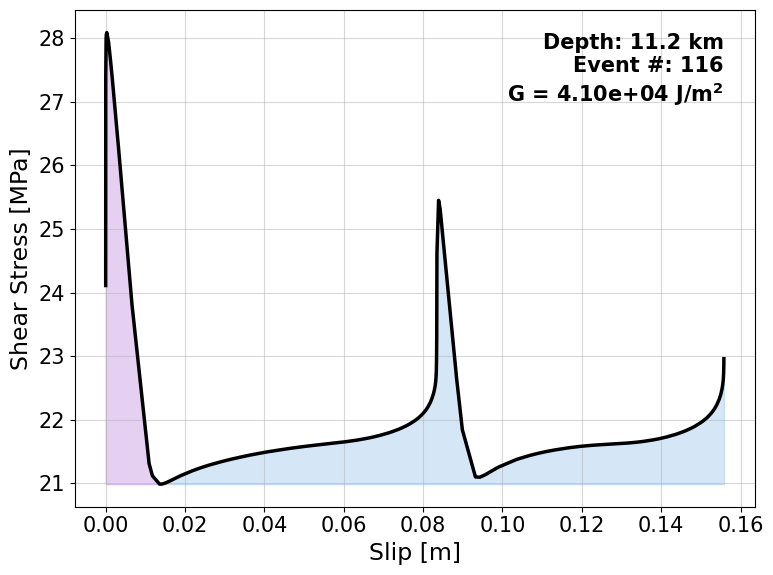

In [74]:
save_on = 0
idep = 56; iev=116
# idep = np.random.randint(0,len(dep)); iev = np.random.randint(spin_up_idx+1,len(tstart))
print(idep,iev)
try:
    plt.rcParams['font.size'] = '15'
    fig,ax = plt.subplots(figsize=(8,6))
    # its,ite = np.argmin(abs(time[idep]-tstart[iev]))-20, np.argmin(abs(time[idep]-tend[iev]))+20
    its,ite = np.argmin(abs(time[idep]-tstart[iev])), np.argmin(abs(time[idep]-tend[iev]))
    x=cumslip[idep][its:ite] - cumslip[idep][its]
    y=shearT[idep][its:ite]
    txt = 'Depth: %2.1f km\nEvent #: %d\nG = %2.2e J/m$\mathbf{^2}$'%(np.sort(abs(dep))[idep],iev,G[iev][idep])
    slip_vs_stress(ax,x,y,txt)
    # slip_vs_stress(ax,x,y)
    # ax.set_xlim(0,0.05e-11)
    # ax.set_ylim(35.2529,35.25295)
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/stress_slip_ev%d_%dm'%(save_dir,iev,int(dep[idep]*1e3)),dpi=300)
    plt.show()
except:
    print('ignore')

#### For interseismic period

65 67


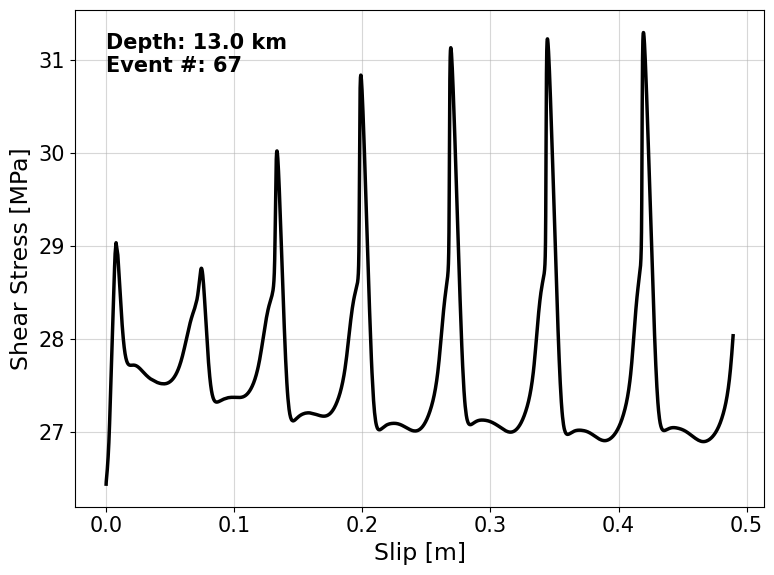

In [19]:
save_on = 1
idep = 65; iev = 67; 
# idep = np.random.randint(0,len(dep)); iev = np.random.randint(spin_up_idx+1,len(tstart))
print(idep,iev)
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,6))
its,ite = np.argmin(abs(time[idep]-tend[iev])), np.argmin(abs(time[idep]-tstart[iev+1]))
x=cumslip[idep][its:ite] - cumslip[idep][its]
y=shearT[idep][its:ite]
txt = 'Depth: %2.1f km\nEvent #: %d'%(np.sort(abs(dep))[idep],iev)
slip_vs_stress_test(ax,x,y,txt)
plt.tight_layout()
if save_on:
    plt.savefig('%s/stress_slip_interev%d_%d_%dm'%(save_dir,iev,iev+1,int(dep[idep]*1e3)),dpi=300)
plt.show()

In [20]:
its,ite

(209879, 218183)

## Collective slip vs. stress plot for a single depth or event

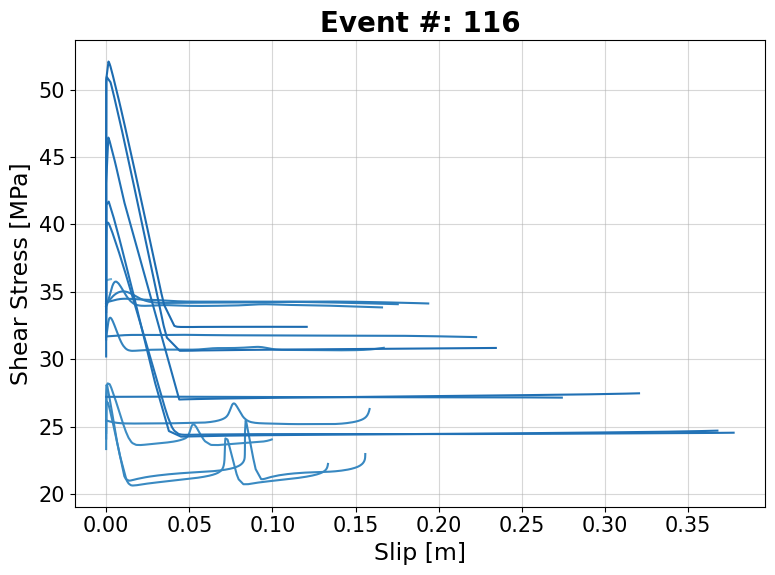

In [61]:
save_on = 0
c = 0
alldepth = True
cmap = mpl.colormaps['Blues']
# iev = 115
iev = np.random.randint(spin_up_idx+1,len(tstart))
idep = np.random.randint(0,len(dep))
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,6))
if alldepth:
    ax.set_title('Event #: %d'%(iev),fontsize=20,fontweight='bold')
    colset = cmap(np.linspace(0.15,0.9,len(dep)))
    for idep in range(len(dep)):
        its,ite = np.argmin(abs(time[idep]-tstart[iev])), np.argmin(abs(time[idep]-tend[iev]))
        x=cumslip[idep][its:ite] - cumslip[idep][its]
        y=shearT[idep][its:ite]
        if len(get_xy(x,y)[0]) != 0 or len(get_xy(x,y)[1]) != 0:
            slip_vs_stress_test(ax,x,y,col=colset[idep],lw=1.5)
            c += 1
else:
    ax.set_title('Depth: %2.1f'%(dep[idep]),fontsize=20,fontweight='bold')
    colset = cmap(np.linspace(0.15,0.9,len(tstart)-spin_up_idx))
    for iev in range(spin_up_idx,len(tstart)):
        its,ite = np.argmin(abs(time[idep]-tstart[iev])), np.argmin(abs(time[idep]-tend[iev]))
        x=cumslip[idep][its:ite] - cumslip[idep][its]
        y=shearT[idep][its:ite]
        if len(get_xy(x,y)[0]) != 0 or len(get_xy(x,y)[1]) != 0:
            slip_vs_stress_test(ax,x,y,col=colset[iev],lw=1.5)
            c += 1
plt.tight_layout()
if save_on:
    plt.savefig('%s/stress_slip_ev%d_%dm'%(plot_dir,iev,int(dep[idep]*1e3)),dpi=300)
plt.show()

In [59]:
len(colset)

83

## AvG & avslip evolution by events

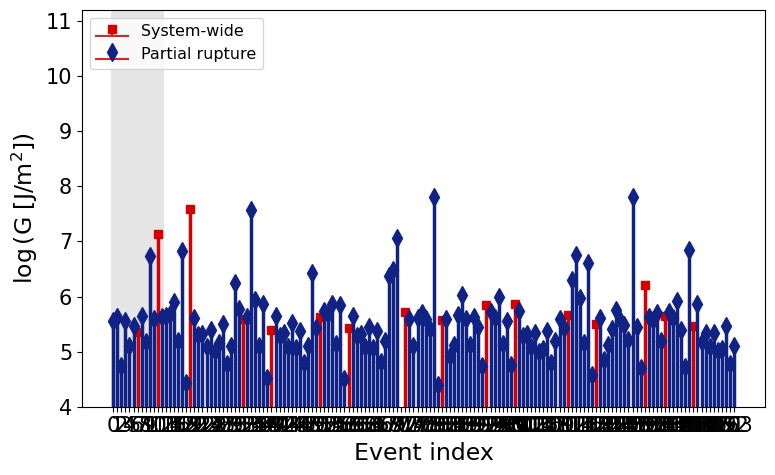

In [36]:
save_on = 0
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,5))
avG_event(ax,avG,tstart,system_wide,partial_rupture,'G',spin_up_idx)
plt.tight_layout()
if save_on:
    plt.savefig('%s/avG_event'%(plot_dir),dpi=300)
plt.show()

## Wb vs Wr

In [ ]:
save_on = 0
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,8))

# sw=scatter_xy(ax,Wr[system_wide[system_wide>=spin_up_idx]],G[system_wide[system_wide>=spin_up_idx]],mp.myburgundy,s=36,marker='s',ec='k',lw=1.5,zord=3)
# pr=scatter_xy(ax,Wr[partial_rupture[partial_rupture>=spin_up_idx]],G[partial_rupture[partial_rupture>=spin_up_idx]],mp.mynavy,s=36,marker='s',ec='k',lw=1.5,zord=3)
sw=scatter_xy(ax,Wr[system_wide[system_wide>=spin_up_idx]],G[system_wide[system_wide>=spin_up_idx]],'None',s=36,marker='s',ec=mp.myburgundy,lw=1.5,zord=3)
pr=scatter_xy(ax,Wr[partial_rupture[partial_rupture>=spin_up_idx]],G[partial_rupture[partial_rupture>=spin_up_idx]],'None',s=36,marker='s',ec=mp.mynavy,lw=1.5,zord=3)
ax.legend([sw,pr],['System-wide','Partial rupture'],fontsize=13,loc='lower right')

plt.tight_layout()
if save_on:
    plt.savefig('%s/Wb_vs_Wr'%(plot_dir),dpi=300)
plt.show()

## Plot for zoomed-in parameters

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(nrows=3,figsize=(8,15))
# idep = 50; iev = 20; 
idep = 12; iev=10
add=200
show_zoom(ax[0],dep,time,tstart,tend,cumslip,idep,iev,add,'cumslip')
ax[0].axes.xaxis.set_ticklabels([])
show_zoom(ax[1],dep,time,tstart,tend,shearT,idep,iev,add,'shearT')
ax[1].axes.xaxis.set_ticklabels([])
show_zoom(ax[2],dep,time,tstart,tend,np.log10(abs(sr)),idep,iev,add,'sr')
plt.tight_layout()
if save_on:
    plt.savefig('%s/zoomin_ev%d_%dm'%(plot_dir,iev,int(dep[idep]*1e3)),dpi=300)
plt.show()

## Scaling law for each model

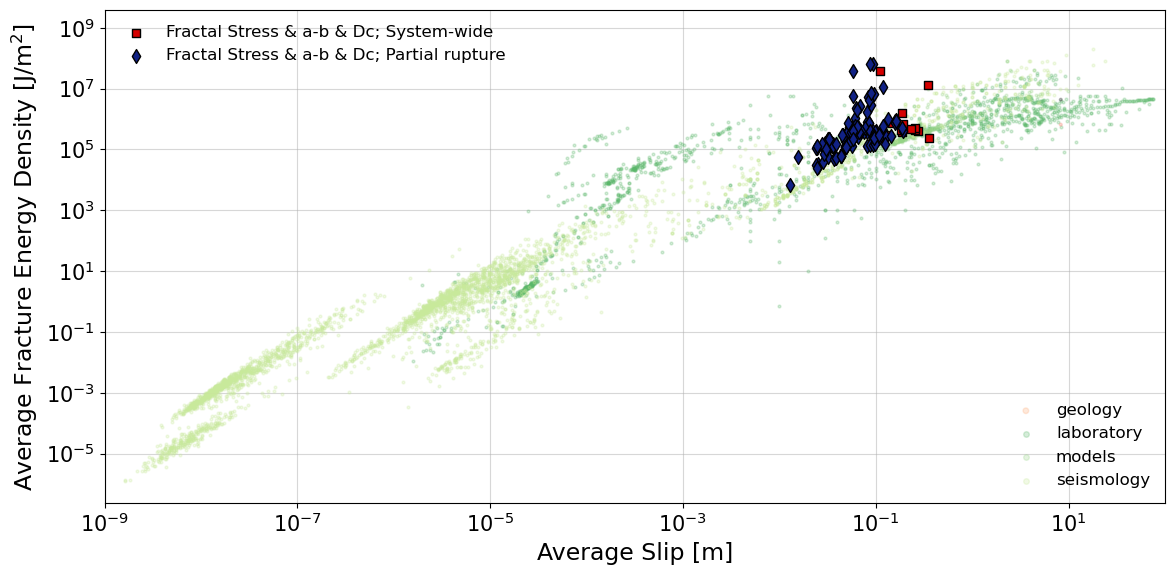

In [37]:
save_on = 0
uu=4
labs = ['BP1','Fractal Stress','Fractal a-b','Fractal Dc','Fractal Stress & a-b & Dc','Fractal Stress & Dc']
cols = [mp.myburgundy,mp.mylavender,mp.mynavy,mp.myblue,mp.myyellow,mp.mypalepink]

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))    
pts,labels = plot_Coccos(ax,follow_color=False,legend_on=False)
first_legend = plt.legend(handles=pts,labels=labels,fontsize=12,framealpha=0,loc='lower right',markerscale=2.)
plt.gca().add_artist(first_legend)

pts = []
sw = scaling(ax,avD[system_wide],avG[system_wide],mp.myburgundy,lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl='auto')
if len(partial_rupture) > 0:
    pr = scaling(ax,avD[partial_rupture],avG[partial_rupture],mp.mynavy,lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl='auto')
    pts.append(sw)
    pts.append(pr)
else:
    pts.append(sw)
ax.legend(fontsize=12,framealpha=0,loc='upper left')
plt.tight_layout()
if save_on:
    plt.savefig('%s/scaling_relation'%(plot_dir))
plt.show()

## Linear proportionality for each model

Estimated coefficients:
b_0 = 6.937834690986123          
b_1 = 1.216091489830009


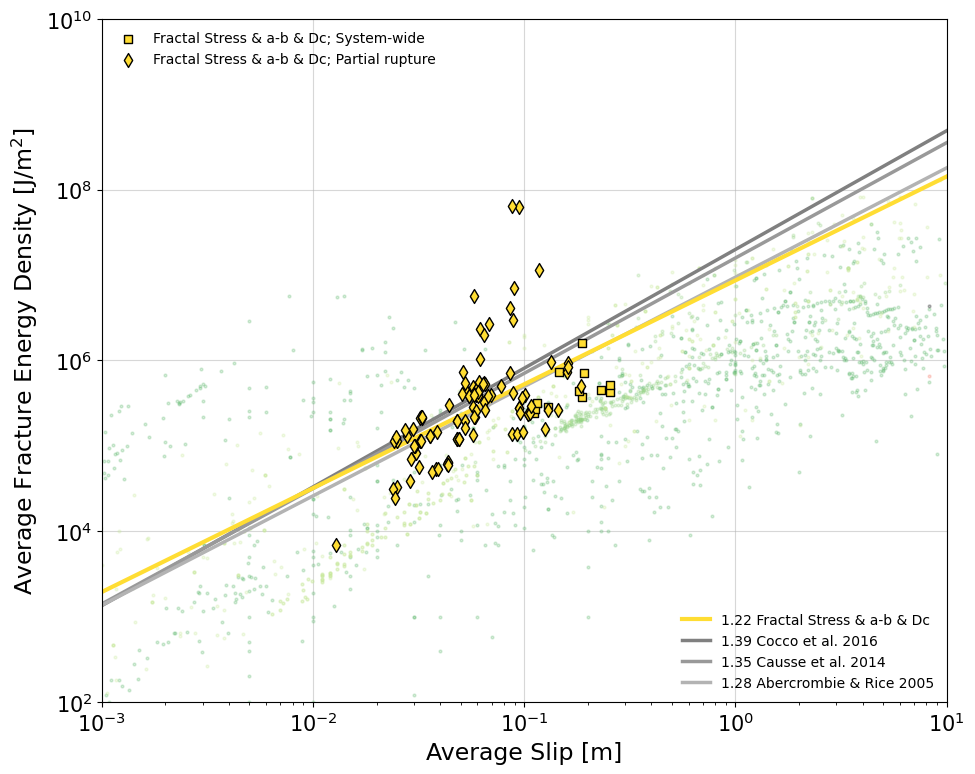

In [10]:
save_on = 0
uu = 4
labs = ['BP1','Fractal Stress','Fractal a-b','Fractal Dc','Fractal Stress & a-b & Dc','Fractal Stress & Dc']
cols = [mp.myburgundy,mp.mylavender,mp.mynavy,mp.myblue,mp.myyellow,mp.mypalepink]
# yr = [1e2,2.5e11]
# xr = [1e-3,1e2]
xr = [1e-3,1e1]
yr = [1e2,1e10]

# prefix = prefix_list[uu]
plot_dir = 'plots/' + prefix

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(10,8))
plot_Coccos(ax,follow_color=False,legend_on=False)

pts = []

outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
G = outputs.item().get('G')
avG = outputs.item().get('avG')
avD = outputs.item().get('avD')
system_wide = outputs.item().get('sw')
partial_rupture = outputs.item().get('pr')
# spin_up_idx = outputs.item().get('spinup')

sw=scaling(ax,avD[system_wide[system_wide>=spin_up_idx]],avG[system_wide[system_wide>=spin_up_idx]],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl=yr,xl=xr)
if len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
    pr=scaling(ax,avD[partial_rupture[partial_rupture>=spin_up_idx]],avG[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl=yr,xl=xr)
    pts.append(sw)
    pts.append(pr)
else:
    pts.append(sw)

first_legend = plt.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.gca().add_artist(first_legend)

if len(partial_rupture) > 0 and sum(partial_rupture>=spin_up_idx) > 0:
    x = np.hstack((avD[system_wide[system_wide>=spin_up_idx]],avD[partial_rupture[partial_rupture>=spin_up_idx]]))
    y = np.hstack((avG[system_wide[system_wide>=spin_up_idx]],avG[partial_rupture[partial_rupture>=spin_up_idx]]))
else:
    x = avD[system_wide[system_wide>=spin_up_idx]]
    y = avG[system_wide[system_wide>=spin_up_idx]]
b = estimate_coef(np.log10(x), np.log10(y))
print("Estimated coefficients:\nb_0 = {}  \
        \nb_1 = {}".format(b[0], b[1]))
y_pred = logxy(xr,b[1],b[0])

factor = 1e6
l1,=ax.plot(xr,logxy(xr,1.39,7.3),'0.5',lw=2.5,label='1.39 Cocco et al. 2016')
l2,=ax.plot(xr,logxy(xr,1.35,7.2),'0.6',lw=2.5,label='1.35 Causse et al. 2014')
l3,=ax.plot(xr,logxy(xr,1.28,6.975),'0.7',lw=2.5,label='1.28 Abercrombie & Rice 2005')
l4,=ax.plot(xr,y_pred,color=cols[uu],lw=3,label='%2.2f %s'%(b[1],labs[uu]))

ax.legend(handles=[l4,l1,l2,l3],fontsize=10,framealpha=0,loc='lower right')

plt.tight_layout()
if save_on:
    plt.savefig('%s/linear_prop_onlyspinup'%(plot_dir),dpi=300)
plt.show()

# Not used

## Scaling law

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))
pts,labels = plot_Coccos(ax,follow_color=False,legend_on=False)
first_legend = plt.legend(handles=pts,labels=labels,fontsize=12,framealpha=0,loc='lower right',markerscale=2.)
plt.gca().add_artist(first_legend)

pts = []
for uu,prefix in enumerate(prefix_list):
    print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')
    print(np.min(np.log10(avG)),np.max(np.log10(avG)))

    sw = scaling(ax,avD[system_wide],avG[system_wide],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl='auto')
    if len(partial_rupture) > 0:
        pr = scaling(ax,avD[partial_rupture],avG[partial_rupture],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl='auto')
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
ax.legend(fontsize=10,framealpha=0,loc='upper left')
plt.tight_layout()
if save_on:
    plt.savefig('scaling_compiled',dpi=300)
plt.show()

## Scaling law - not averaged

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))
pts,labels = plot_Coccos(ax,follow_color=False,legend_on=False)
first_legend = plt.legend(handles=pts,labels=labels,fontsize=12,framealpha=0,loc='lower right',markerscale=2.)
plt.gca().add_artist(first_legend)

pts = []
for uu,prefix in enumerate(prefix_list):
    print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    D = outputs.item().get('D')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw = scaling(ax,D[system_wide],G[system_wide],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl='auto')
    if len(partial_rupture) > 0:
        pr = scaling(ax,D[partial_rupture],G[partial_rupture],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl='auto')
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
ax.legend(fontsize=10,framealpha=0,loc='upper left')
plt.tight_layout()
if save_on:
    plt.savefig('scaling_compiled_not_av',dpi=300)
plt.show()

## Scaling law before spin-up

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))
pts,labels = plot_Coccos(ax,follow_color=False,legend_on=False)
first_legend = plt.legend(handles=pts,labels=labels,fontsize=12,framealpha=0,loc='lower right',markerscale=2.)
plt.gca().add_artist(first_legend)

pts = []
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw = scaling(ax,avD[system_wide],avG[system_wide],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl='auto')
    if sum(system_wide<=spin_up_idx) > 0:
        spsw = scaling(ax,avD[system_wide[system_wide<=spin_up_idx]],avG[system_wide[system_wide<=spin_up_idx]],'0.75',lab='Before spin-up; System-wide',s=36,marker='s',ec='0.2',lw=1,zord=3,yl='auto')
    if len(partial_rupture) > 0:
        pr = scaling(ax,avD[partial_rupture],avG[partial_rupture],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl='auto')
        if sum(partial_rupture<spin_up_idx) > 0:
            sppr = scaling(ax,avD[partial_rupture[partial_rupture<spin_up_idx]],avG[partial_rupture[partial_rupture<spin_up_idx]],'0.75',lab='Before spin-up; Partial rupture',s=50,marker='d',ec='0.2',lw=1,zord=3,yl='auto')
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
pts.append(spsw)
pts.append(sppr)
ax.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.tight_layout()
if save_on:
    plt.savefig('scaling_compiled_before_spinup',dpi=300)
plt.show()

## Scaling law before spin-up - not averaged

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))
pts,labels = plot_Coccos(ax,follow_color=False,legend_on=False)
first_legend = plt.legend(handles=pts,labels=labels,fontsize=12,framealpha=0,loc='lower right',markerscale=2.)
plt.gca().add_artist(first_legend)

pts = []
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    D = outputs.item().get('D')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw = scaling(ax,D[system_wide],G[system_wide],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl='auto')
    if sum(system_wide<=spin_up_idx) > 0:
        spsw = scaling(ax,D[system_wide[system_wide<=spin_up_idx]],G[system_wide[system_wide<=spin_up_idx]],'0.75',lab='Before spin-up; System-wide',s=36,marker='s',ec='0.2',lw=1,zord=3,yl='auto')
    if len(partial_rupture) > 0:
        pr = scaling(ax,D[partial_rupture],G[partial_rupture],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl='auto')
        if sum(partial_rupture<spin_up_idx) > 0:
            sppr = scaling(ax,D[partial_rupture[partial_rupture<spin_up_idx]],G[partial_rupture[partial_rupture<spin_up_idx]],'0.75',lab='Before spin-up; Partial rupture',s=50,marker='d',ec='0.2',lw=1,zord=3,yl='auto')
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
pts.append(spsw)
pts.append(sppr)
ax.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.tight_layout()
if save_on:
    plt.savefig('scaling_compiled_before_spinup_not_av',dpi=300)
plt.show()

## Scaling law after spin-up

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(12,6))
pts,labels = plot_Coccos(ax,follow_color=False,legend_on=False)
first_legend = plt.legend(handles=pts,labels=labels,fontsize=12,framealpha=0,loc='lower right',markerscale=2.)
plt.gca().add_artist(first_legend)

pts = []
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw = scaling(ax,avD[system_wide[system_wide>=spin_up_idx]],avG[system_wide[system_wide>=spin_up_idx]],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl='auto')
    if len(partial_rupture) > 0 and sum(partial_rupture<spin_up_idx) > 0:
        pr = scaling(ax,avD[partial_rupture[partial_rupture>=spin_up_idx]],avG[partial_rupture[partial_rupture>=spin_up_idx]],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl='auto')
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
        
ax.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.tight_layout()
if save_on:
    plt.savefig('scaling_compiled_after_spinup',dpi=300)
plt.show()

## Linear proportionality - all data

In [ ]:
save_on = 1
xr = [1e-3,1e1]
yr = [1e2,2.5e11]

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(10,8))
plot_Coccos(ax,follow_color=False,legend_on=False)

pts = []
for uu,prefix in enumerate(prefix_list):
    # print(prefix)
    # print('Load saved data: %s/outputs.npy'%(prefix))
    outputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
    G = outputs.item().get('G')
    avG = outputs.item().get('avG')
    avD = outputs.item().get('avD')
    system_wide = outputs.item().get('sw')
    partial_rupture = outputs.item().get('pr')
    spin_up_idx = outputs.item().get('spinup')

    sw=scaling(ax,avD[system_wide],avG[system_wide],cols[uu],lab='%s; System-wide'%(labs[uu]),s=36,marker='s',ec='k',lw=1,zord=3,yl=yr,xl=xr)
    if len(partial_rupture) > 0:
        pr=scaling(ax,avD[partial_rupture],avG[partial_rupture],cols[uu],lab='%s; Partial rupture'%(labs[uu]),s=50,marker='d',ec='k',lw=1,zord=3,yl=yr,xl=xr)
        pts.append(sw)
        pts.append(pr)
    else:
        pts.append(sw)
first_legend = plt.legend(handles=pts,fontsize=10,framealpha=0,loc='upper left')
plt.gca().add_artist(first_legend)

l1,=ax.plot(xr,logxy(xr,1.39,7.3),'0.5',lw=2.5,label='1.39 Cocco et al. 2016')
l2,=ax.plot(xr,logxy(xr,1.35,7.2),'0.6',lw=2.5,label='1.35 Causse et al. 2014')
l3,=ax.plot(xr,logxy(xr,1.28,6.975),'0.7',lw=2.5,label='1.28 Abercrombie & Rice 2005')

ax.legend(handles=[l1,l2,l3],fontsize=10,framealpha=0,loc='lower right')

plt.tight_layout()
if save_on:
    plt.savefig('linear_prop_all',dpi=300)
plt.show()